In [2]:
%matplotlib inline

import qiskit
from qiskit import *

from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
IBMQ.load_account();  provider = IBMQ.get_provider()
sim = Aer.get_backend('qasm_simulator'); qcomp = provider.get_backend('ibmq_16_melbourne'); vector_sim = Aer.get_backend('statevector_simulator')

print(qiskit.__qiskit_version__)

ibmqfactory.load_account:WARNING:2020-06-22 12:22:22,006: Credentials are already in use. The existing account in the session will be replaced.


{'qiskit-terra': '0.14.1', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.0', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.1', 'qiskit': '0.19.3'}


In [101]:
# This is the BB84 Protocol, that uses a quantum and classical channel to generate a secure secret key. This key can be used and instantly destroyed, making it extremely safe.
# This protocol involves randomly choosing bits to send, and also the basis in which to send them, so some are in X basis (superposition) and some are in the Z basis (nomral).
# This prevents an evesdropper from listening, since measuring a qubit would destroy its state, and qubits can't be cloned due to the no-cloning theorem.


#Defining Length of secret key - note that only ~half length will be used for real key.
n = 32

#Importing numpy for random number generation
import numpy as np
key_bits = np.random.choice(2, n)
basis = np.random.choice(2, n)


In [102]:
#Let's double check that the bits are roughly random
print(basis.mean())
print(key_bits.mean())

0.46875
0.46875


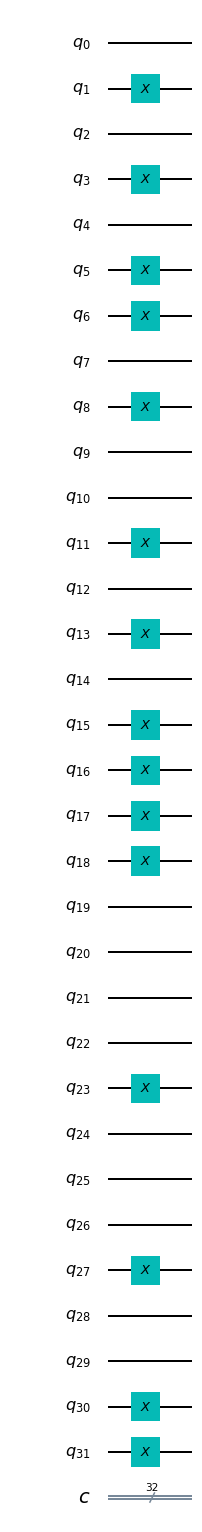

In [103]:
#Now we need to send the key data. There are two steps - 1. Encode the value (from key_bits array) to the qubits. 2. Puts qubits in superposition (from basis array)

#Defining Quantum Circuit
qc = QuantumCircuit(n, n)

# Step 1 - All qubits are initially 0. Hence, to change them to 1, we will use X gate
for i in range(len(key_bits)):
    if key_bits[i] == 1:
        qc.x(i)
    else:
        pass
qc.draw('mpl')

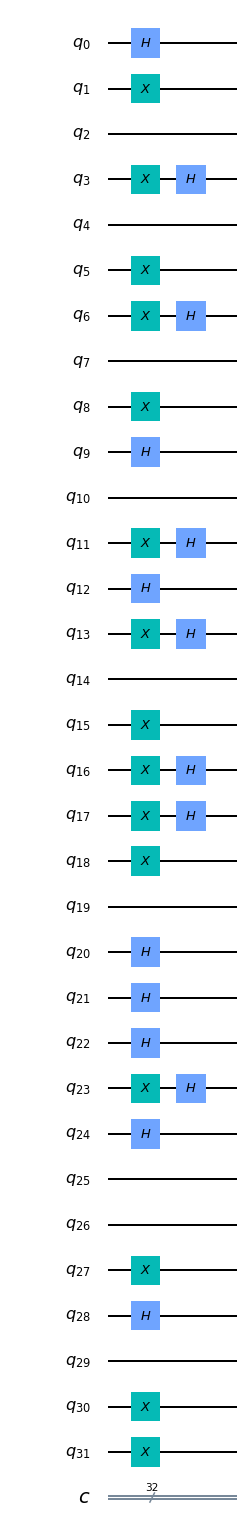

In [104]:
#Step 2 - Randomly put qubits into superposition using basis array.

# To put a qubit in superposition, we need to use the hadamard gate.
for i in range(len(basis)):
    if basis[i] == 1:
        qc.h(i)
    else:
        pass

qc.draw('mpl')

In [105]:
#Good, we can see that some of the qubits have both X and H, some have only X, or only H, and some have none. This looks quite random.

#Now we move on to decode the message, and receive the secret key. Now we only need 1 array - which basis to measure in. 
#Since reciever doesn't need to generate a random message, he only needs to randomly decide which basis to use.

dec_basis = np.random.choice(2, n)

#See if it is random
print(dec_basis.mean())

0.53125


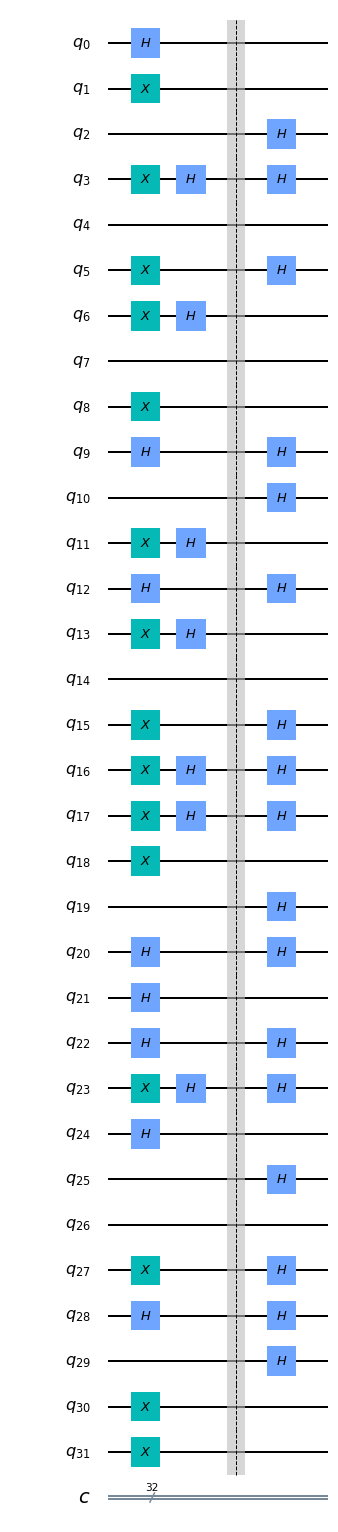

In [106]:
# Now we will repeat the basis loop, and add hadamard to change basis, whereever dec_basis is 1.

#Adding Barrier to distinguish encoding and decoding.
qc.barrier()

#Changing state randomly
for i in range(len(dec_basis)):
    if dec_basis[i] == 1:
        qc.h(i)
    else:
        pass

qc.draw('mpl')

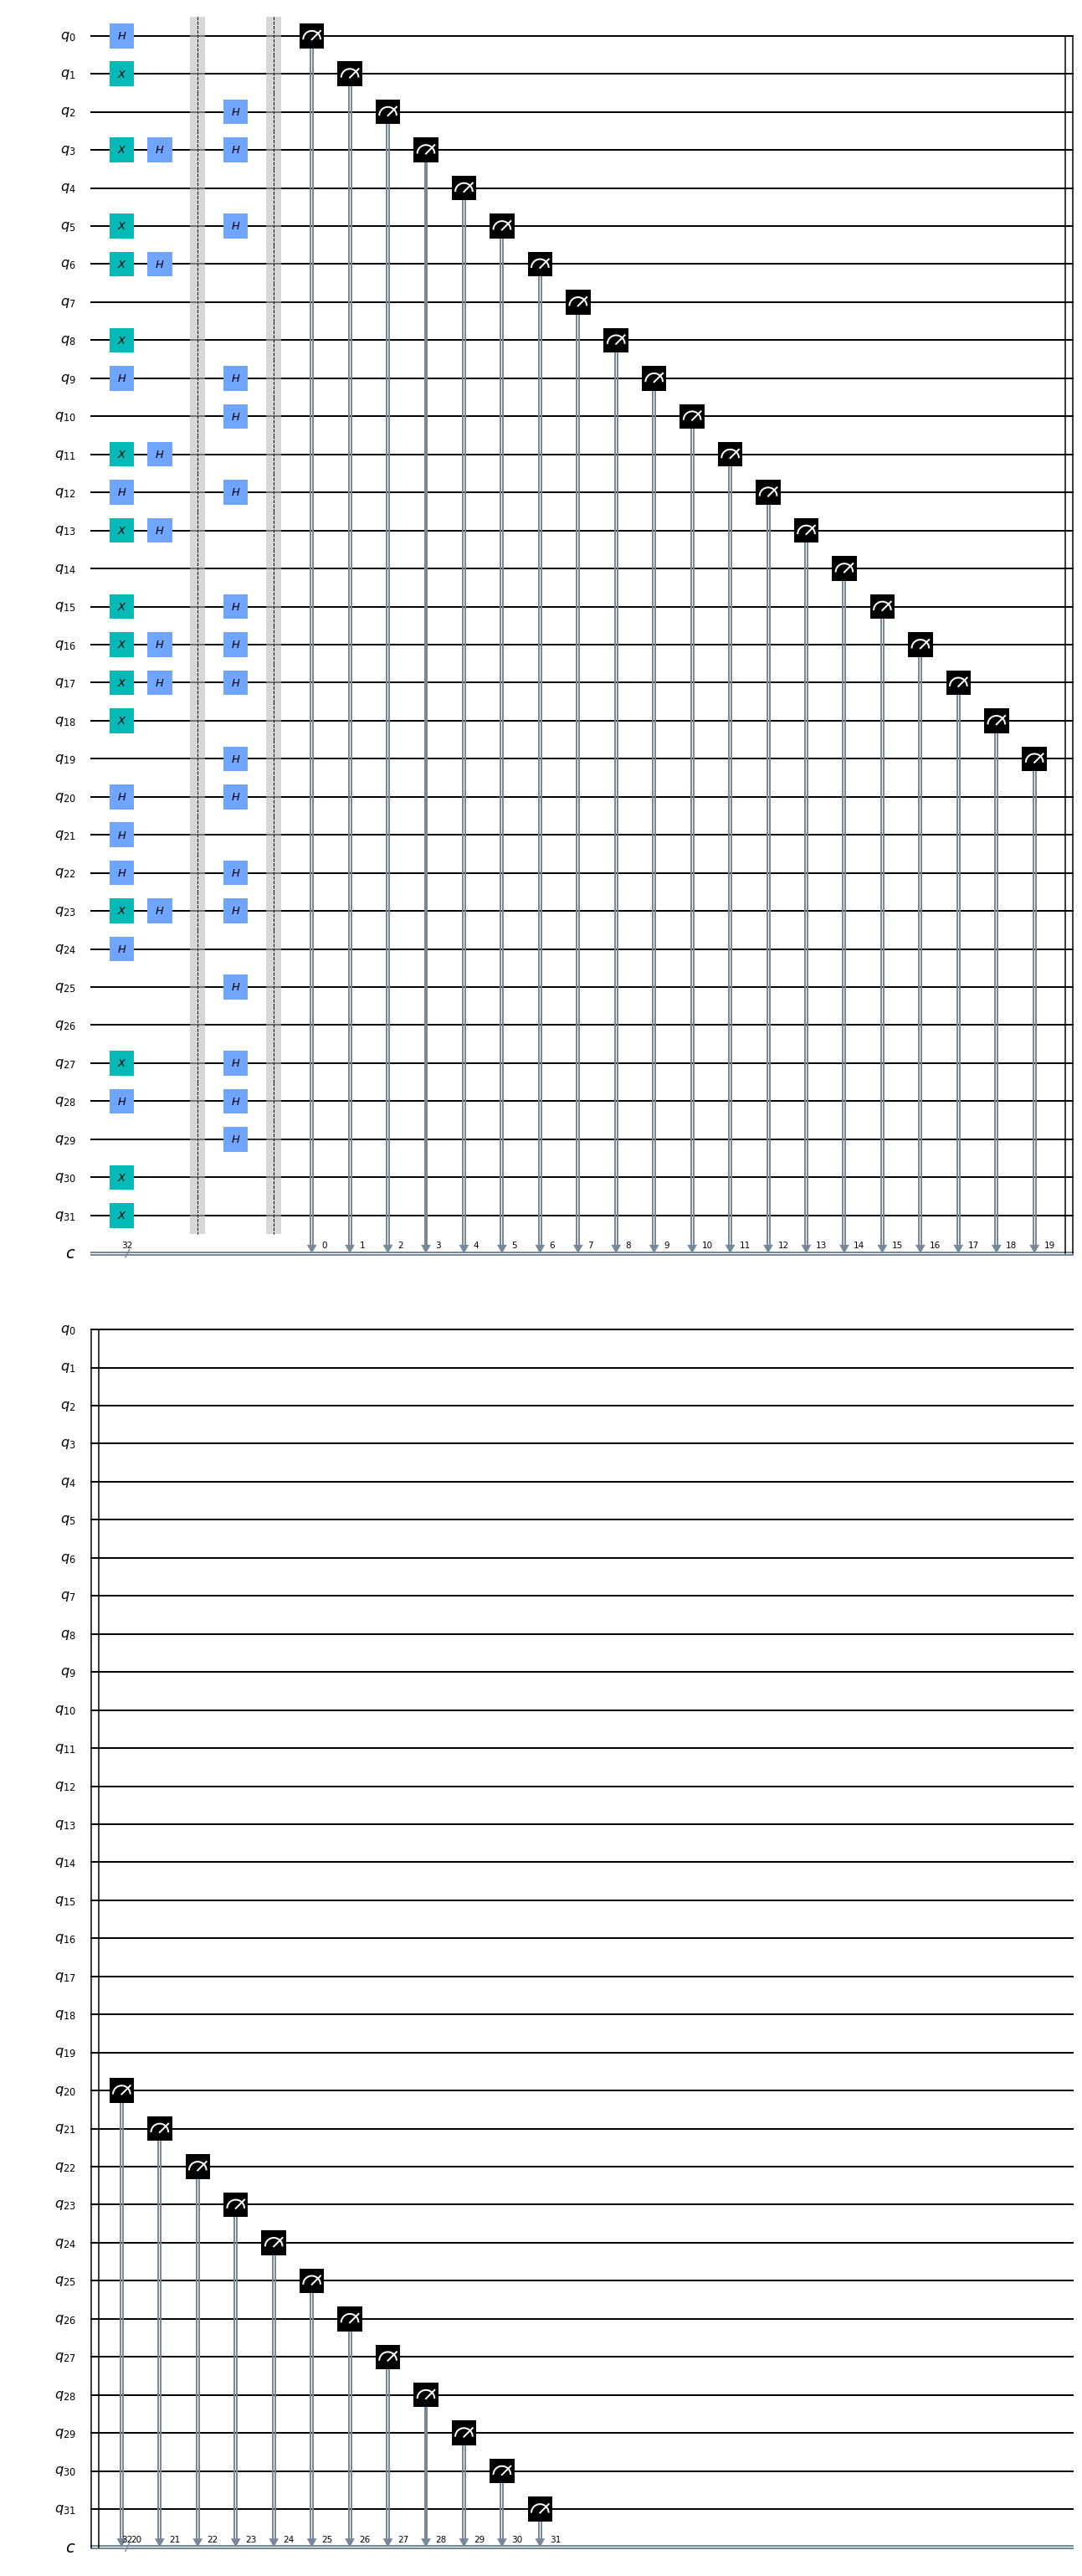

In [107]:
#We can see that almost 50% of the time, reciever chooses the wrong base, but as we will see, it doesn't matter.
#Last thing left to add is for reciever to measure all qubits.
qc.barrier()
qc.measure(range(n), range(n))

qc.draw('mpl')

In [108]:
#We have finished the quantum part of the circuit. Now we need to compare which qubits did the reciever and sender use the same basis.

match = np.zeros(n)
for i in range(n):
    if basis[i] == dec_basis[i]:
        match[i] = 1
    else:
        match[i] = 0

print(match.mean())

0.5625


In [109]:
match

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.])

In [110]:
# Roughly half, but not exact due to small number of trials.

#Running the Circuit will give the results. If you only take the qubits where there was a match, you get a secret key.
result = execute(qc, backend=sim, shots=1).result()

counts = result.get_counts()
max_key = max(counts, key=counts.get)
max_key

'11001000101011111010100100001010'

In [111]:
import pandas as pd
data = pd.DataFrame(columns=['match', 'record', 'send'])
data['match'] = match
temp = list(max_key)
temp.reverse()
data['record'] = np.array(temp)
data['send'] = key_bits
data[data['match'] == 1.0]

,match,record,send
1,1.0,1,1
3,1.0,1,1
4,1.0,0,0
7,1.0,0,0
8,1.0,1,1
9,1.0,0,0
12,1.0,0,0
14,1.0,0,0
16,1.0,1,1
17,1.0,1,1


In [ ]:
#We have managed to isolate qubits which match 100% of the time without disclosing their values. However, this is primitive, since there is no way to realize whether there is a 3rd party listening.
# For this, all we need to do, is take a subset of the qubits (including the ones they got wrong) and check receivers accuracy. It should be close to 75%. If there is an intruder, accuracy will go down to 62.5$
# We will run this accuracy check with and without intruder to see how it goes.

